In [1]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import datetime

from causal_gen.basic_ts import generate_data
from sklearn.linear_model import LinearRegression

## Function to get root and parents of each node in the causal graph

In [2]:
def get_root_parents_node(causal_graph):
    node_parents = {}
    root = list()
    for node in causal_graph.nodes:
        predecessors = list(causal_graph.predecessors(node))
        if predecessors:
            node_parents[node] = predecessors
            ## since there could be a case, a value of a node at time t is caused by it previous own value
            if len(predecessors) == 1 and predecessors[0] == node:
                root.append(node)
        else:
            root.append(node)
    return root, node_parents

## Function to process timeseries data
Assuming that each column in a row/tuple in the dataframe df shares the same timestamp.

The process_timeseries_data function will return a new dataframe data such that a tuple represent the values of parent nodes and their children.

In [3]:
def get_target_level(data, df, path, node_levels, target_node):
    target_level = None
    for level, node in enumerate(path):
        if level == 0: ## the root node
            data[node] = df[node]
        else:
            data[node] = df[node].shift(-level)

        if node == target_node:
            target_level = level
        node_levels[node] = target_level

    return target_level, data

def process_timeseries_data(df, dag, target_node):
    """
    df : pandas.DataFrame
    dag : nx.DiGraph
    target_node : string
    """
    all_nodes = list(nx.topological_sort(dag))
    data = pd.DataFrame(columns=all_nodes)

    longest_path = nx.dag_longest_path(dag)
    target_level = None
    seen = dict()

    if target_node in longest_path:
        for level, node in enumerate(longest_path):
            if level == 0: ## the root node
                data[node] = df[node]
            else:
                data[node] = df[node].shift(-level)

            if node == target_node:
                target_level = level
            seen[node] = target_level

    # just in case the target_node is not in the longest path
    if target_level is None:
        for node in all_nodes:
            try:
                path = nx.shortest_path(dag, source=node, target=target_node)
                target_level, data = get_target_level(data, df, path, seen, target_node)
            except nx.exception.NetworkXNoPath:
                continue

    ## now check the rest of the nodes that have not been seen
    unseen = list(set(all_nodes) - set(seen.keys()))

    for node in unseen:
        if node not in seen:
            try:
                path = nx.shortest_path(dag, source=node, target=target_node)
                len_path = len(path)
                for i, vertex in enumerate(path):
                    if vertex not in seen:
                        seen[vertex] = i
                        diff = len_path - i - 1
                        level = target_level - diff
                        data[vertex] = df[vertex].shift(-level)
            except nx.exception.NetworkXNoPath:
                seen[node] = 0
                data[node] = df[node]
    #data = data.dropna()
    return data, target_level

In [4]:
features = ('X1', 'X2', 'X3', 'X4', 'X5')

causal_graph = nx.DiGraph([('X1','X2'),
                          ('X2','X3'),
                          ('X3','X4'),
                          ('X5','X4')])

data = {
    'X1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    'X2': ['a2', 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], ## 2 * X1(t-1)
    'X3': ['a3', 'b3', 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], ## X2(t-1) + 1
    'X5': ['a5', 'b5', 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 
    'X4': ['a4', 'b4', 'c4', 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45] ## X3(t-1) + X5(t-1)
}

df = pd.DataFrame(data)
df

,X1,X2,X3,X5,X4
0,1,a2,a3,a5,a4
1,2,2,b3,b5,b4
2,3,4,3,3,c4
3,4,6,5,4,9
4,5,8,7,5,12
5,6,10,9,6,15
6,7,12,11,7,18
7,8,14,13,8,21
8,9,16,15,9,24
9,10,18,17,10,27


In [5]:
df_lagged, target_level = process_timeseries_data(df, causal_graph, target_node='X4')
df_lagged

,X1,X5,X2,X3,X4
0,1,3,2,3,9
1,2,4,4,5,12
2,3,5,6,7,15
3,4,6,8,9,18
4,5,7,10,11,21
5,6,8,12,13,24
6,7,9,14,15,27
7,8,10,16,17,30
8,9,11,18,19,33
9,10,12,20,21,36


## Function to train FCM on each node based on the given causal graph

In [6]:
def get_lagged_values(df, target_node, parents, lag=1):
    df_lagged = df[[target_node]]
    lagged_vars = list()
    for vertex in parents:
        vertex_lag = f'{vertex}_lag'
        lagged_vars.append(vertex_lag)
        if lag == 1:
            df_lagged[vertex_lag] = df[vertex].shift(lag)
    return df_lagged, lagged_vars

data = {
    'Y': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'X': [0, 1, 2, 3, 4, 5, 6, 7, 8]
}

df = pd.DataFrame(data)
df_lagged, lagged_vars = get_lagged_values(df, target_node = 'Y', parents = ['X'], lag=1)
df_lagged

,Y,X_lag
0,1,NaN
1,2,0.0
2,3,1.0
3,4,2.0
4,5,3.0
5,6,4.0
6,7,5.0
7,8,6.0
8,9,7.0


In [7]:
def learn_fcm_of_timeseries(df, causal_graph, lag=1):
    fcm = dict()
    for node in causal_graph.nodes:
        predecessors = list(causal_graph.predecessors(node))
        # print(f'-----------------------------------------------------------')
        # print(f'finding fcm of node {node}, its parents are {predecessors}')
        if predecessors:
            df_lagged, lagged_vars = get_lagged_values (df = df, 
                                                        target_node = node, 
                                                        parents=predecessors, 
                                                        lag=lag)
            df_lagged = df_lagged.dropna()
            # print(f'df_lagged.columns = {df_lagged.columns}')
            predictors = df_lagged[lagged_vars]
            # print(f'predictors are {lagged_vars}')
            target = df_lagged[node]
            model = LinearRegression()
            model.fit(predictors, target)
            fcm[node] = (lagged_vars, model)
        else:
            fcm[node] = None
        # print(f'-----------------------------------------------------------')
    return fcm

In [8]:
features = ('X1', 'X2', 'X3', 'X4', 'X5')

causal_graph = nx.DiGraph([('X1','X2'),
                          ('X2','X3'),
                          ('X3','X4'),
                          ('X5','X4')])

data = {
    'X1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    'X2': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], ## 2 * X1(t-1)
    'X3': [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], ## X2(t-1) + 1
    'X5': [1, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 
    'X4': [1, 2, 3, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45] ## X3(t-1) + X5(t-1)
}

df = pd.DataFrame(data)
fcm = learn_fcm_of_timeseries(df, causal_graph, lag=1)

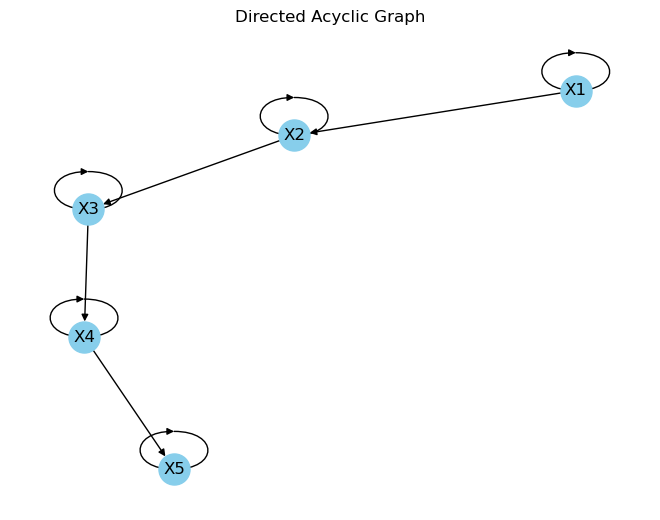

root is ['X1']
node_parents {'X1': ['X1'], 'X2': ['X1', 'X2'], 'X3': ['X2', 'X3'], 'X4': ['X3', 'X4'], 'X5': ['X4', 'X5']}


{'X1': (['X1_lag'], LinearRegression()),
 'X2': (['X1_lag', 'X2_lag'], LinearRegression()),
 'X3': (['X2_lag', 'X3_lag'], LinearRegression()),
 'X4': (['X3_lag', 'X4_lag'], LinearRegression()),
 'X5': (['X4_lag', 'X5_lag'], LinearRegression())}

In [9]:
features = ('X1', 'X2', 'X3', 'X4', 'X5')
causal_graph = nx.DiGraph([('X1', 'X1'),
                          ('X1', 'X2'), 
                          ('X2', 'X2'), 
                          ('X2', 'X3'),
                          ('X3', 'X3'),
                          ('X3', 'X4'),
                          ('X4', 'X4'),
                          ('X4', 'X5'),
                          ('X5', 'X5'),])
# Plot the DAG
pos = nx.spring_layout(causal_graph)  # Position the nodes using a layout algorithm (e.g., spring_layout)
nx.draw(causal_graph, pos, with_labels=True, node_size=500, node_color='skyblue', arrows=True)
plt.title("Directed Acyclic Graph")
plt.show()

df = pd.read_csv('timeseries1.csv')
df.columns  = features

root, node_parents = get_root_parents_node(causal_graph)
print(f'root is {root}')
print(f'node_parents {node_parents}')

fcm = learn_fcm_of_timeseries(df, causal_graph, lag=1)
fcm

## Function to inject an outlier into a dataframe

In [10]:
def inject_an_outlier(df,
                      original_df_stats,
                      fcm, 
                      causal_graph,
                      node_parents,
                      target_node,
                      root_cause,
                      target_node_position,
                      multiplier = 5):
    n_features = df.shape[1]
    has_path = nx.has_path(causal_graph, 
                           source=root_cause, 
                           target=target_node)
    if not has_path:
        print(f'No path from {root_cause} to {target_node}')
        return
    
    ## determine outlier value at the root cause node
    mean_root_cause = original_df_stats['mean'][root_cause]
    std_root_cause = original_df_stats['std'][root_cause]
    min_val = original_df_stats['min'][root_cause]
    max_val = original_df_stats['max'][root_cause]
    root_cause_outlier_val = mean_root_cause + (multiplier * std_root_cause) + random.uniform(min_val, max_val)
    
    ## path from the root cause to the target node
    path = nx.shortest_path(causal_graph, 
                            source=root_cause, 
                            target=target_node)
    distance = len(path) - 1
    
    path_vals = {}
    for node in path:
        node_pos_in_path_from_target = distance - path.index(node) 
        ## get position of the node relative to the target_node
        rel_node_position = target_node_position - node_pos_in_path_from_target 
        
        if node == root_cause:
            path_vals[node] = root_cause_outlier_val
            df.at[rel_node_position, node] = path_vals[node]
            continue
        
        parents = node_parents[node]
        X = {}
        for parent in parents: 
            parent_val = path_vals.get(parent)
            if parent_val:
                X[f'{parent}_lag'] = parent_val
            else: ## just in case the parent is not part of the path
                ## get parent position relative to the target node
                rel_parent_pos = rel_node_position - 1
                X[f'{parent}_lag'] = df.loc[rel_parent_pos, parent]
        # print(f'X is {X}')
        X_pd = pd.DataFrame([X])
        predictor_vars, node_fcm = fcm[node]
        # print(f'predictor_vars {predictor_vars}')
        X_array = X_pd[predictor_vars].values
        path_vals[node] = node_fcm.predict(X_array)
        df.at[rel_node_position, node] = path_vals[node]

In [11]:
features = ('X1', 'X2', 'X3', 'X4', 'X5')

causal_graph = nx.DiGraph([('X1','X2'),
                          ('X2','X3'),
                          ('X3','X4'),
                          ('X5','X4')])

data = {
    'X1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    'X2': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], ## 2 * X1(t-1)
    'X3': [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], ## X2(t-1) + 1
    'X5': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 
    'X4': [1, 2, 4, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42] ## X3(t-1) + X5(t-1)
}
df = pd.DataFrame(data)
df

,X1,X2,X3,X5,X4
0,1,1,1,1,1
1,2,2,2,2,2
2,3,4,3,3,4
3,4,6,5,4,6
4,5,8,7,5,9
5,6,10,9,6,12
6,7,12,11,7,15
7,8,14,13,8,18
8,9,16,15,9,21
9,10,18,17,10,24


In [12]:
def get_original_df_stats(df):
    original_df_stats = {}
    original_df_stats['mean'] = {}
    original_df_stats['std'] = {}
    original_df_stats['min'] = {}
    original_df_stats['max'] = {}
    for col in df.columns:
        original_df_stats['mean'][col] = df[col].mean()
        original_df_stats['std'][col] = df[col].std()
        original_df_stats['min'][col] = df[col].min()
        original_df_stats['max'][col] = df[col].max()
    return original_df_stats
        
fcm = learn_fcm_of_timeseries(df, causal_graph, lag=1)
root, node_parents = get_root_parents_node(causal_graph)
original_df_stats = get_original_df_stats(df)
inject_an_outlier(df, 
                  original_df_stats,
                  fcm, 
                  causal_graph,
                  node_parents,
                  target_node='X4',
                  root_cause='X1',
                  target_node_position=10,
                  multiplier = 5)
df

,X1,X2,X3,X5,X4
0,1.000000,1.000000,1.000000,1,1.000000
1,2.000000,2.000000,2.000000,2,2.000000
2,3.000000,4.000000,3.000000,3,4.000000
3,4.000000,6.000000,5.000000,4,6.000000
4,5.000000,8.000000,7.000000,5,9.000000
5,6.000000,10.000000,9.000000,6,12.000000
6,7.000000,12.000000,11.000000,7,15.000000
7,34.914312,14.000000,13.000000,8,18.000000
8,9.000000,69.828624,15.000000,9,21.000000
9,10.000000,18.000000,70.828624,10,24.000000


## Function to inject n outliers into the dataframe
Assuming that each column in a row/tuple in the dataframe df shares the same timestamp.

In [13]:
def inject_n_outliers(df,
                      causal_graph,
                      target_node,
                      root_cause,
                      n_outliers,
                      multiplier = 5,
                      lag = 1):
    n_data = df.shape[0]
    if n_outliers < 1:
        n_outliers = int(n_outliers * n_data)
    
    target_outlier_positions = random.sample(range(len(causal_graph.nodes), n_data), 
                                     n_outliers)
    target_outlier_positions = tuple(sorted(target_outlier_positions))
    
    fcm = learn_fcm_of_timeseries(df, causal_graph, lag=lag)
    root, node_parents = get_root_parents_node(causal_graph)
    original_df_stats = get_original_df_stats(df)
    
    for target_outlier_position in target_outlier_positions:
        inject_an_outlier(df, 
                          original_df_stats,
                          fcm, 
                          causal_graph,
                          node_parents,
                          target_node,
                          root_cause,
                          target_node_position=target_outlier_position,
                          multiplier = multiplier)

In [14]:
features = ('X1', 'X2', 'X3', 'X4', 'X5')

causal_graph = nx.DiGraph([('X1','X2'),
                          ('X2','X3'),
                          ('X3','X4'),
                          ('X5','X4')])

data = {
    'X1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    'X2': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], ## 2 * X1(t-1)
    'X3': [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], ## X2(t-1) + 1
    'X5': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 
    'X4': [1, 2, 4, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42] ## X3(t-1) + X5(t-1)
}
df = pd.DataFrame(data)
inject_n_outliers(df,
                  causal_graph,
                  target_node='X4',
                  root_cause='X1',
                  n_outliers=2,
                  multiplier = 5,
                  lag = 1)
df

,X1,X2,X3,X5,X4
0,1.000000,1.000000,1.000000,1,1.000000
1,2.000000,2.000000,2.000000,2,2.000000
2,3.000000,4.000000,3.000000,3,4.000000
3,4.000000,6.000000,5.000000,4,6.000000
4,5.000000,8.000000,7.000000,5,9.000000
5,6.000000,10.000000,9.000000,6,12.000000
6,7.000000,12.000000,11.000000,7,15.000000
7,43.174209,14.000000,13.000000,8,18.000000
8,9.000000,86.348417,15.000000,9,21.000000
9,10.000000,18.000000,87.348417,10,24.000000
